# 1. Setup

In [1]:
from mobilkit.umni import *
import contextily as ctx

warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.1. Load data

### 1.1.1. Zones (TIGER)

In [2]:
zones = gpd.read_parquet('../data/zones/in_2010.parquet').set_crs(CRS_DEG).disp(0)

6,417 rows x 7 cols; Memory: 1.8 MiB; CRS: EPSG:4326


geoid     scale      cbsa    county    aland   awater    geometry
  <object>  <object>  <object>  <object>  <int64>  <int64>  <geometry>

### 1.1.2. Census (ACS)

In [3]:
acs = pd.read_parquet('../data/ses/acs_in_2019.parquet').disp(0)

6,407 rows x 25 cols; Memory: 1.9 MiB


scale     geoid       popu pop_density    p_minor      p_poc   p_lowedu  \
  <object>  <object>  <float64>   <float64>  <float64>  <float64>  <float64>   

   m_income      p_pov   p_pov150   p_pov200     p_snap p_unemploy  p_noinsur  \
  <float64>  <float64>  <float64>  <float64>  <float64>  <float64>  <float64>   

 p_disabled p_lowenglish p_snglparent  p_crowded   p_renter p_mobilehome  \
  <float64>    <float64>    <float64>  <float64>  <float64>    <float64>   

    p_noveh m_hhperveh    p_nowfh  p_transit p_walkbike  
  <float64>  <float64>  <float64>  <float64>  <float64>

### 1.1.3. POIs (SafeGraph)

In [4]:
pois = gpd.read_parquet('../data/pois/in_2020.parquet').set_crs(CRS_DEG).disp(0)

80,742 rows x 8 cols; Memory: 24.9 MiB; CRS: EPSG:4326


id   purpose      kind sg_category    geometry       area   visits  \
  <object>  <object>  <object>    <object>  <geometry>  <float64>  <int32>   

 visitors  
  <int32>

### 1.1.4. OD travel times
<!-- Convert distances from unidirectional to bidirectional. -->

In [7]:
od = pd.read_parquet('../../spr_4711/data/gdm/odp_in_2010.parquet')
od = od[od.day_type == 'weekday']
od['mode'] = od['mode'].str.upper()
same = (od.groupby(['scale', 'mode', 'src_geoid'], observed=True).size().reset_index()
        .assign(trg_geoid=lambda df: df.src_geoid).assign(time=0).drop(columns=0))
od = pd.concat([od, same]).reset_index(drop=1).astype(D(time=np.float32) | {
    x: CAT for x in ['src_geoid', 'trg_geoid', 'mode', 'scale']}).disp()

7,026,290 rows x 8 cols; Memory: 128.7 MiB


src_geoid    trg_geoid       dist       time      speed       scale  \
    <category>   <category>  <float32>  <float32>  <float32>  <category>   
0  18105001304  18105001301     4480.0     3268.0   1.370869       tract   

         mode    day_type  
   <category>  <category>  
0     TRANSIT     weekday

### 1.1.5. Impedance function

In [8]:
imped_params = (
    pd.read_csv('../data/nhts/fitted-params-power-exponential.csv')
    .query('measure == "Duration" & parameter != "r2"')
    .assign(purpose=lambda df: df.purpose.str.replace('Other', 'Services'))
    .assign(mode=lambda df: df['mode'].str.upper())
).disp()

38 rows x 5 cols; Memory: 0.0 MiB


measure      mode   purpose parameter      value
   <object>  <object>  <object>  <object>  <float64>
0  Duration      BIKE   Overall     alpha   0.025914

# 2. Accessibility measure

## 2.1. Non-work (POI) access

In [9]:
def get_poi_access(zones=zones, acs=acs, pois=pois, od=od, 
                   imped_params=imped_params, 
                   thresholds=(15, 30, 45, 60, 90),
                   wt_method='count', overwrite=False):
    """Compute the proposed accessibility to POIs per person 
    for all the zones.

    Parameters
    ----------
    zones : GeoDataFrame
        Table of zones at different scales.
    acs : DataFrame
        Census data table containing the population column `popu`.
    pois : GeoDataFrame
        Table of POIs classified by `purpose` and `kind`.
    od : DataFrame
        Table having distance/travel time value for each zone OD pair.
    imped_params : DataFrame
        Table containing the power exponential impedance 
        function parameters α and β.
    thresholds : arraylike[float]
        Travel time thresholds (in minutes).
    wt_method : str
        Method to weight POI attractiveness; one of 
        {"count", "area", "visits"}.
        TODO: Add support for "area" and "visits".
    eps : float
        A small tolerance value to avoid division by zero error.

    Returns
    -------
    Pdf
        Table containing POI accessibility value for each zone
    """
    outpath = Path('../data/access/in_poi_2010.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    zones = zones.merge(acs, on='geoid')[['geoid', 'popu', 'geometry']]
    pois = pois.sjoin(zones[['geoid', 'geometry']], predicate='within')
    pois = (pois.groupby(['geoid', 'purpose', 'kind'])
            .agg(D(count=D(id='count'), visits=D(visits=sum), 
                   area=D(area=sum))[wt_method])
            .iloc[:, 0].rename('opport').reset_index())
    params = imped_params.query('purpose != "Work"')
    res = []
    pbar = tqdm(total=4 * 4 * len(thresholds)) # modes x purposes x thresh
    for mode, d1 in od.groupby('mode', sort=False): # each mode
        for thresh in thresholds: # each threshold
            coef = (params[params['mode'] == mode]
                    .pivot_table('value', 'purpose', 'parameter'))
            for purpose, d2 in coef.iterrows(): # each purpose
                pbar.update()
                pbar.set_description('purpose={}, mode={}, thresh={} min'
                                     .format(mode.title(), purpose, thresh))
                time = (d1[d1['time'] / 60 <= thresh]
                        .set_index(['src_geoid', 'trg_geoid'])
                        ['time'].rename('weight') / 60)
                wtd = np.exp(-d2.alpha * time ** d2.beta)
                unwtd = Seq(1, name='weight', index=wtd.index)
                wt = pd.concat([wtd.reset_index().assign(wt_decay=True),
                                unwtd.reset_index().assign(wt_decay=False)])
                wt = wt.merge(pois, left_on='trg_geoid', right_on='geoid')
                wt = wt.astype({'src_geoid': str})
                wt['access'] = wt['opport'] * wt['weight']
                df = (wt.groupby(['src_geoid', 'wt_decay'])['access'].sum()
                      .reset_index().assign(kind='Overall'))
                if purpose != 'Overall':
                    df2 = (wt[wt['purpose'] == purpose]
                           .groupby(['src_geoid', 'kind', 'wt_decay'])
                           ['access'].sum().reset_index())
                    df = pd.concat([df, df2])
                df = df.rename(columns={'src_geoid': 'geoid'})
                res.append(df.assign(purpose=purpose, mode=mode, thresh=thresh))
    grp_cols = ['purpose', 'kind', 'mode', 'thresh', 'geoid']
    xs = (pd.concat(res).reset_index(drop=True)
          .rename(columns={'src_geoid': 'geoid'})
          .merge(zones[['geoid', 'popu']], on='geoid')
          .astype(D(thresh=str)).astype({x: CAT for x in grp_cols}))
    xs_pp = xs.assign(per_person=True, access=xs['access'] / xs['popu'])
    xs = (pd.concat([xs.assign(per_person=False), xs_pp])
          .reset_index(drop=True).astype(D(access=np.float32))
          [grp_cols + ['wt_decay', 'per_person', 'access']])
    xs.to_parquet(U.mkfile(outpath))
    return xs

xs = get_poi_access(overwrite=0).disp() # t=7:51
# xs = get_poi_access(overwrite=1); xs

5,370,400 rows x 8 cols; Memory: 62.1 MiB


purpose        kind        mode      thresh       geoid wt_decay  \
   <category>  <category>  <category>  <category>  <category>   <bool>   
0     Overall     Overall       DRIVE          15       18001    False   

  per_person     access  
      <bool>  <float32>  
0      False     1353.0

# 3. Visualize

In [10]:
def plot_map_access(scale, mode, thresh, purpose='Overall',
                    kind='Overall', wt_decay=True, xs=xs, zones=zones,
                    size=(8, 16), dpi=120, cmap='rainbow',
                    vmin=None, vmax=None):
    cnty = zones.query('scale == "COUNTY"').to_crs(CRS_M)
    zones = zones.query(f'scale=="{scale}"')[['geoid', 'geometry']]
    xs = xs.query('mode=="{}" & thresh=="{}" & purpose=="{}" & kind=="{}"'
                  .format(mode, thresh, purpose, kind))
    xs = xs[xs['wt_decay'] == wt_decay]
    # xs = (zones.merge(xs, 'left', 'geoid').to_crs(CRS_M)
    #       [['geometry', 'access']].fillna(0))
    xs = zones.merge(xs, on='geoid').to_crs(CRS_M)
    title = ('Accessibility to {} POIs ({}) at {}\n scale within {} minutes by {}'
             .format(kind.lower(), purpose, scale, thresh, mode.title()))
    ax = U.plot(size=size, dpi=dpi, axoff=1, title=title)
    xs.plot(ax=ax, column='access', cmap=cmap, legend=True,
            edgecolor='k', lw=0.1, vmin=vmin, vmax=vmax, legend_kwds=dict(
                shrink=0.4, label='Accessibility per 1000 persons'))
    cnty.plot(ax=ax, ec='k', lw=1, facecolor='none')

# plot_map_access('TRACT', 'TRANSIT', 30, vmin=0.5, vmax=5)

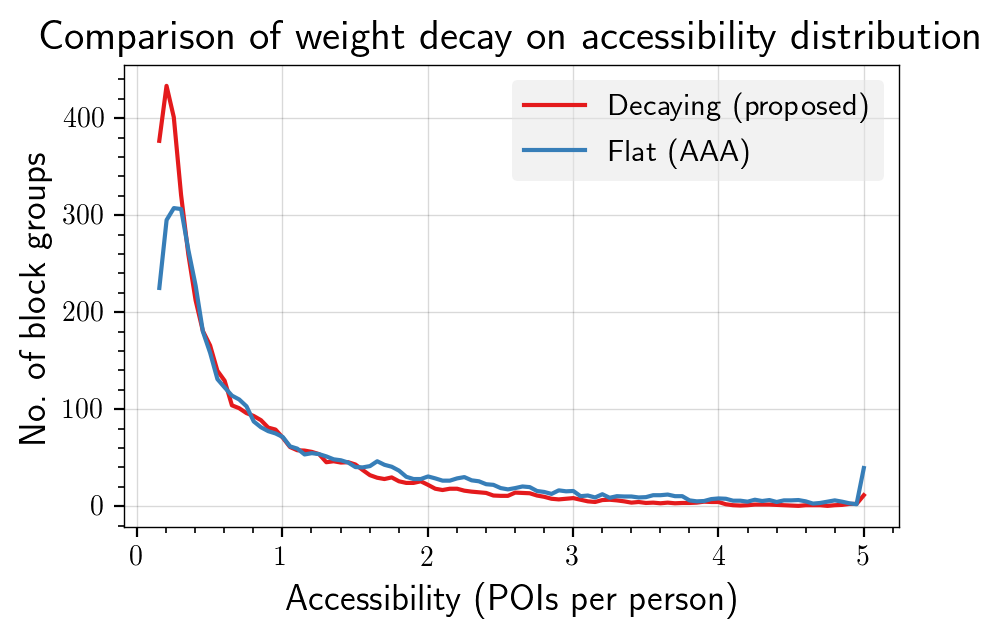

In [11]:
df = xs.query('per_person & mode=="DRIVE" & thresh=="15" & purpose=="Overall"')
df = df[df.geoid.str.len() == 12] # filter block groups
df.wt_decay = df.wt_decay.map({True: 'Decaying (proposed)', False: 'Flat (AAA)'})
ax = U.plot(size=(5, 3), xlab='Accessibility (POIs per person)',
            title='Comparison of weight decay on accessibility distribution',
            ylab='No. of block groups', ylog=0, dpi=200)
for (wt_decay, d), color in zip(df.groupby('wt_decay'), sns.color_palette('Set1', 2)):
    y, x = np.histogram(d.access.clip(0, 5), bins=100)
    ax.plot(x[1:], Seq(y).rolling(3).mean(), label=wt_decay, color=color)
ax.legend();

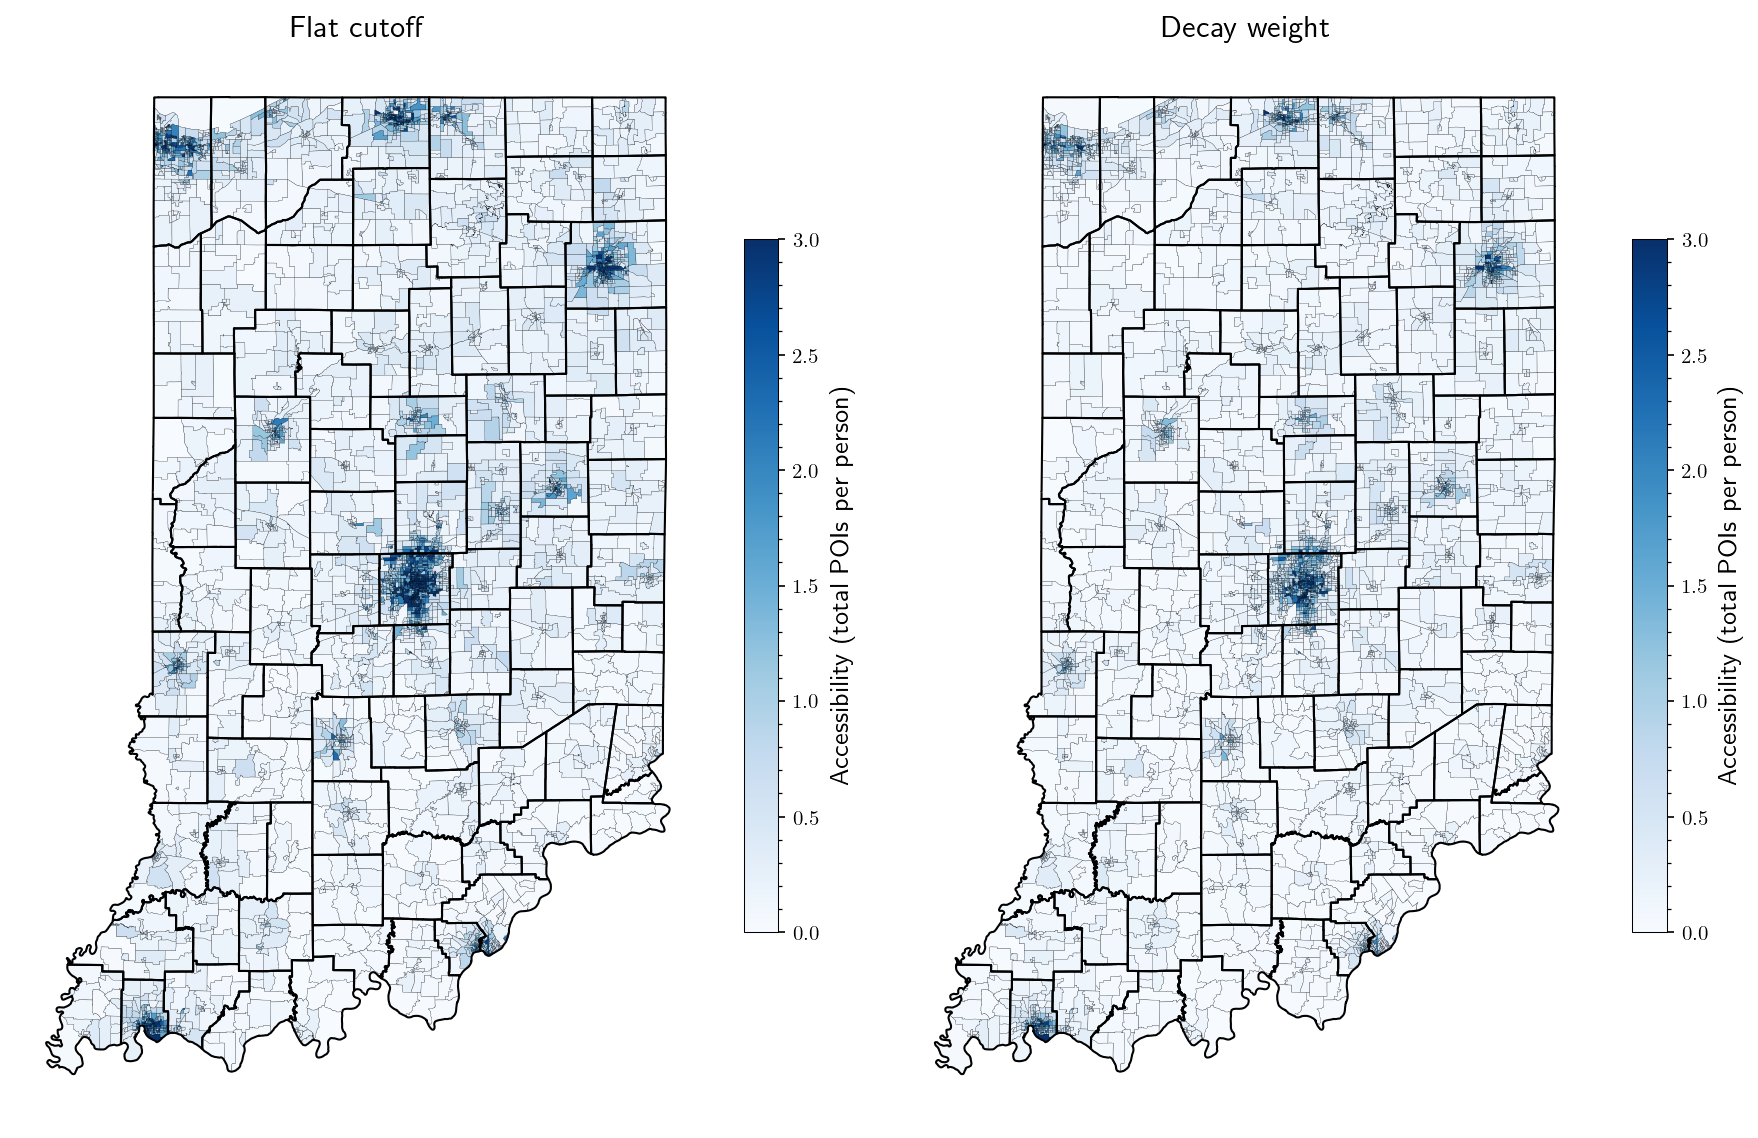

In [12]:
# t=0:07
df = xs.query('per_person & mode=="DRIVE" & thresh=="15" & purpose=="Overall"')
_, axes = plt.subplots(1, 2, figsize=(12, 8), dpi=150)
for ax, (wt_decay, d) in zip(axes, zones[['geoid','geometry','scale']]
                             .merge(df, on='geoid').groupby('wt_decay')):
    ax = U.plot(ax, title='Decay weight' if wt_decay else 'Flat cutoff', axoff=1)
    d.to_crs(CRS_M).plot(ax=ax, column='access', legend=True, cmap='Blues',
                         vmin=0, vmax=3, ec='k', lw=0.1, legend_kwds=dict(
                             shrink=0.6, label='Accessibility (total POIs per person)'))
    zones.query('scale=="COUNTY"').to_crs(CRS_M).plot(ax=ax, ec='k', lw=1, fc='none')
plt.tight_layout()

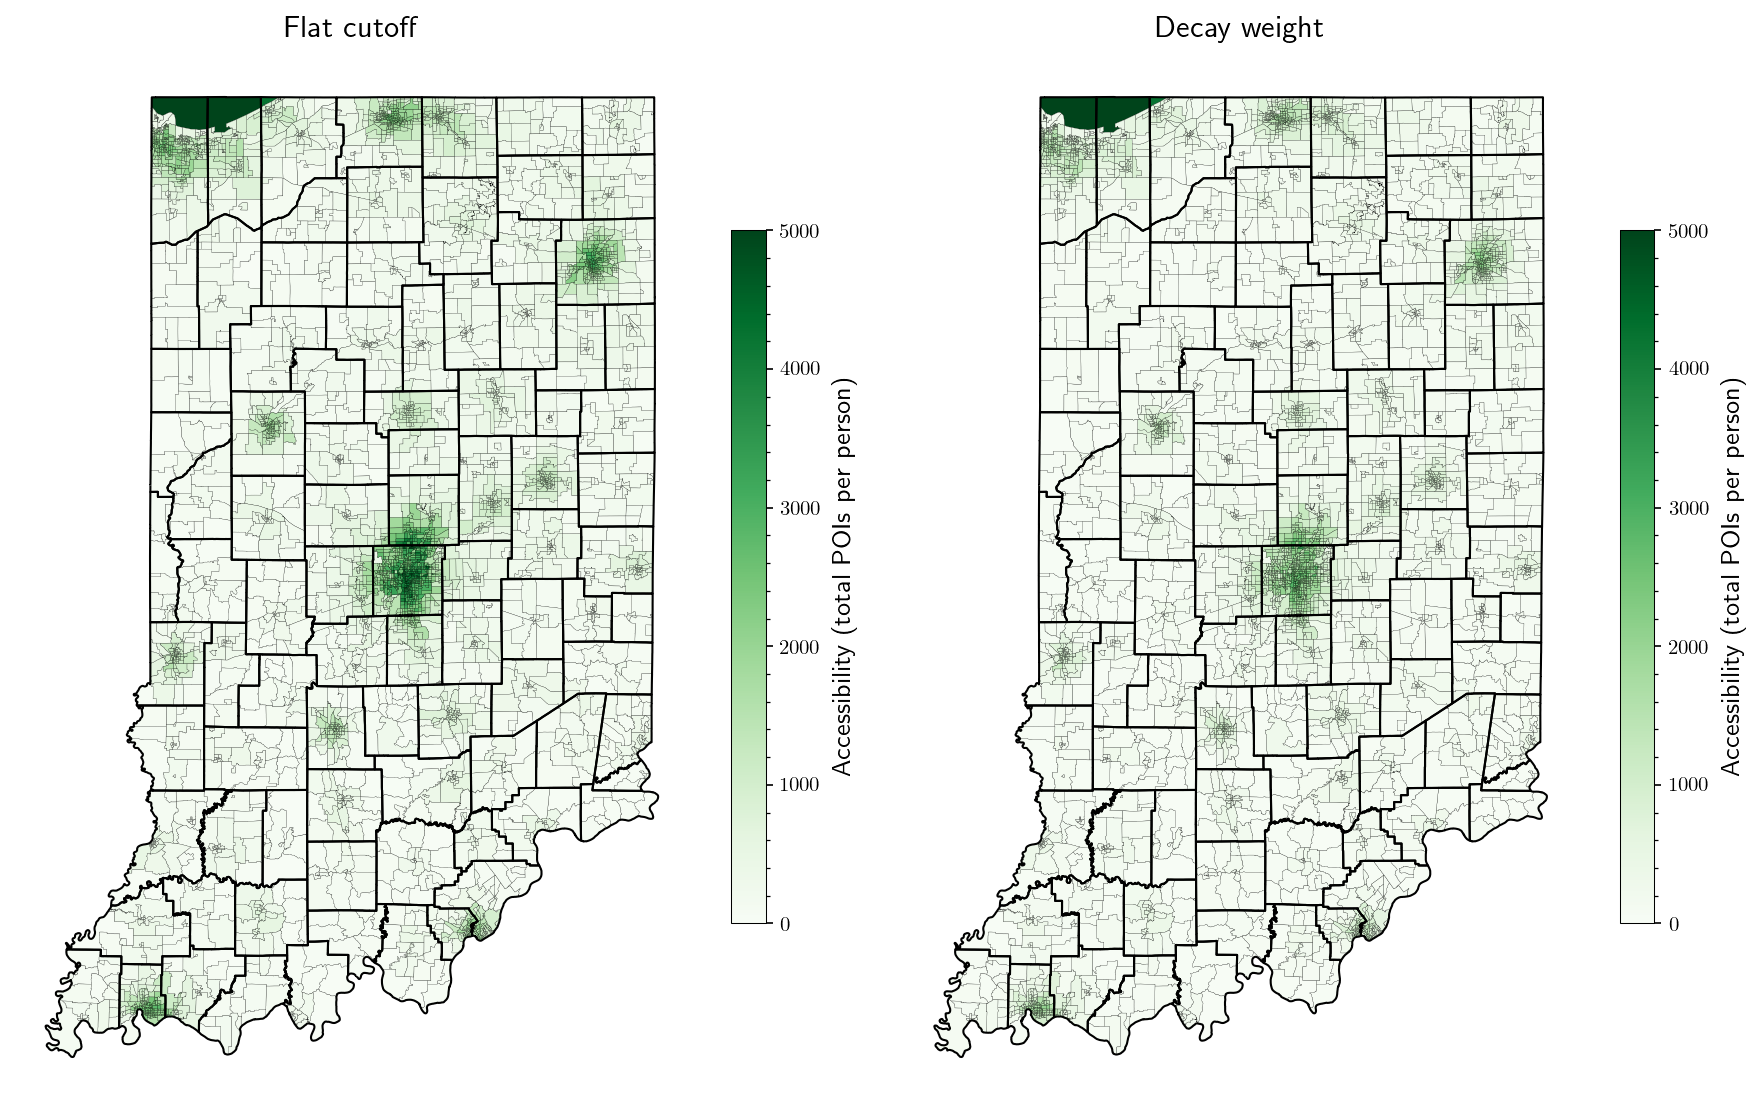

In [13]:
# t=0:10
df = xs.query('~per_person & mode=="DRIVE" & thresh=="15" & purpose=="Overall"')
_, axes = plt.subplots(1, 2, figsize=(12, 8), dpi=150)
for ax, (wt_decay, d) in zip(axes, zones[['geoid','geometry','scale']]
                             .merge(df, on='geoid').groupby('wt_decay')):
    ax = U.plot(ax, title='Decay weight' if wt_decay else 'Flat cutoff', axoff=1)
    d.to_crs(CRS_M).plot(ax=ax, column='access', legend=True, cmap='Greens',
                         vmin=0, vmax=5e3, ec='k', lw=0.1, legend_kwds=dict(
                             shrink=0.6, label='Accessibility (total POIs per person)'))
    zones.query('scale=="COUNTY"').to_crs(CRS_M).plot(ax=ax, ec='k', lw=1, fc='none')
plt.tight_layout()

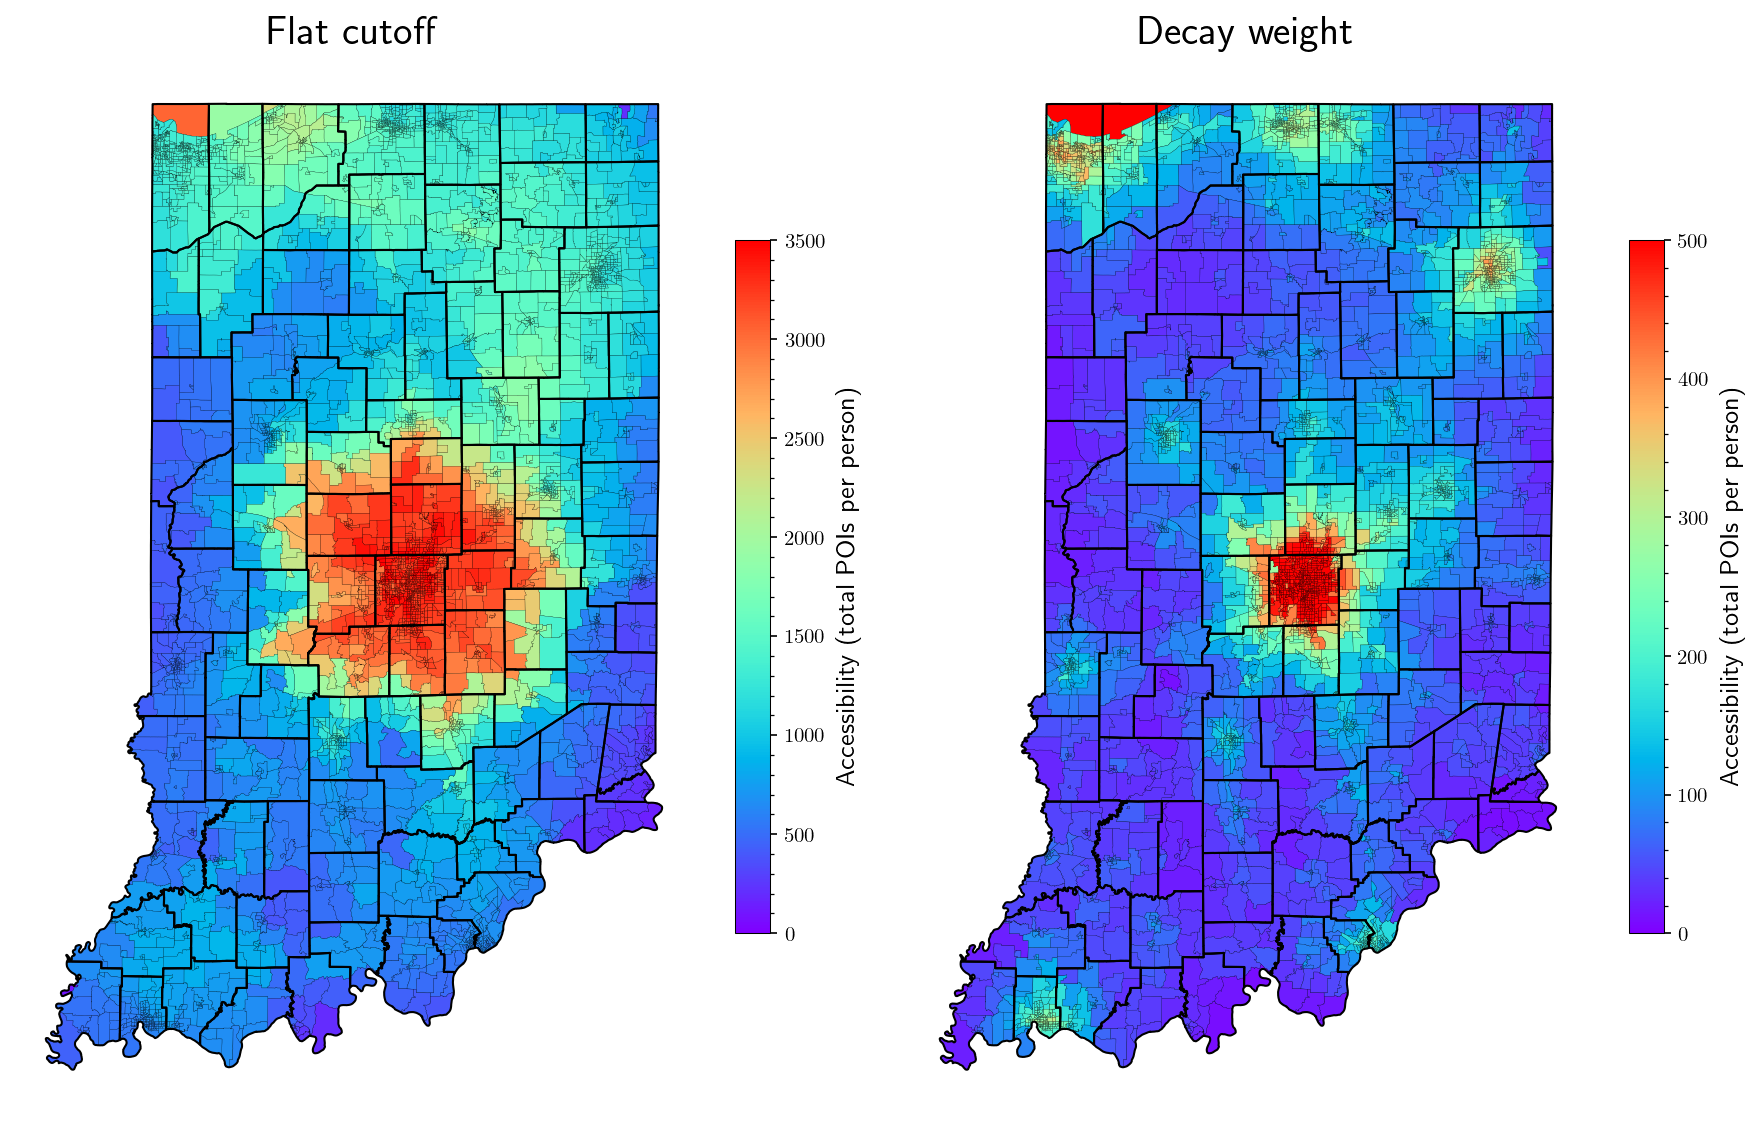

In [14]:
# t=0:10
df = xs.query('~per_person & mode=="DRIVE" & thresh=="60" & kind=="Essential"')
_, axes = plt.subplots(1, 2, figsize=(12, 8), dpi=150)
for ax, (wt_decay, d) in zip(axes, zones.query('aland > 0')[['geoid','geometry','scale']]
                             .merge(df, on='geoid').groupby('wt_decay')):
    ax = U.plot(ax, axoff=1)
    ax.set_title('Decay weight' if wt_decay else 'Flat cutoff', fontsize=20)
    d.to_crs(CRS_M).plot(ax=ax, column='access', legend=True, cmap='rainbow',
                         vmin=0, vmax=500 if wt_decay else 3500, ec='k', lw=0.1, legend_kwds=dict(
                             shrink=0.6, label='Accessibility (total POIs per person)'))
    zones.query('scale=="COUNTY"').to_crs(CRS_M).plot(ax=ax, ec='k', lw=1, fc='none')
plt.tight_layout()

In [15]:
xs.query('purpose=="Overall" & kind=="Overall" & wt_decay').pivot_table('access', 'geoid', 'per_person').corr()

per_person     False     True 
per_person                    
False       1.000000  0.140151
True        0.140151  1.000000

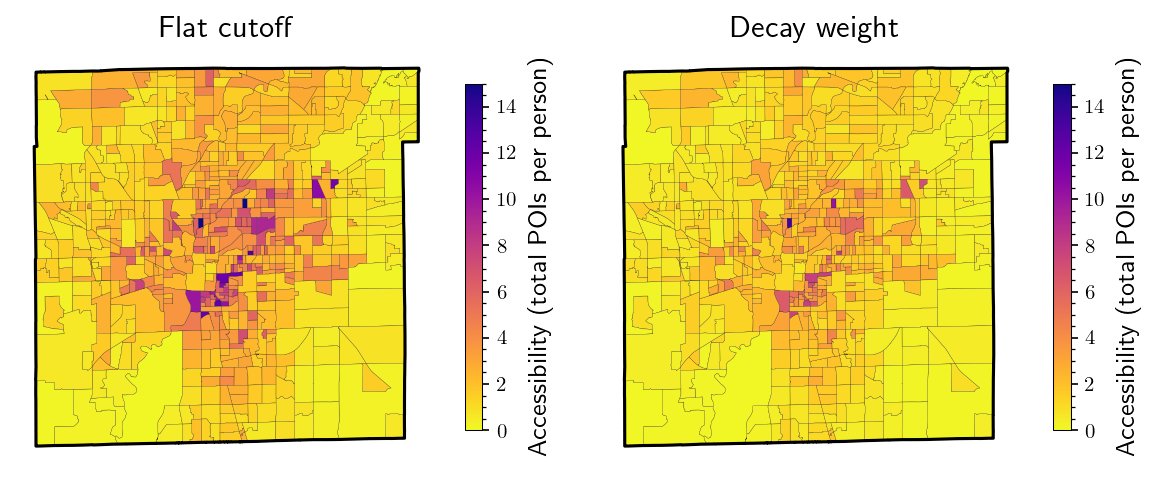

In [17]:
df = xs.query('per_person & mode=="DRIVE" & thresh=="15" & purpose=="Overall"')
d2 = zones.merge(df[(df.geoid.str.len()==12) & (df.geoid.str.startswith('18097'))]).to_crs(CRS_M)
_, axes = plt.subplots(1, 2, figsize=(8, 8), dpi=150)
for ax, (wt_decay, d) in zip(axes, d2.groupby('wt_decay')):
    ax = U.plot(ax, title='Decay weight' if wt_decay else 'Flat cutoff', axoff=1)
    d.plot(ax=ax, column='access', legend=True, cmap='plasma_r',
           vmin=0, vmax=15, ec='k', lw=0.1, legend_kwds=dict(
               shrink=0.3, label='Accessibility (total POIs per person)'))
    d.dissolve().plot(ax=ax, fc='none', ec='k', lw=1.5)
plt.tight_layout()

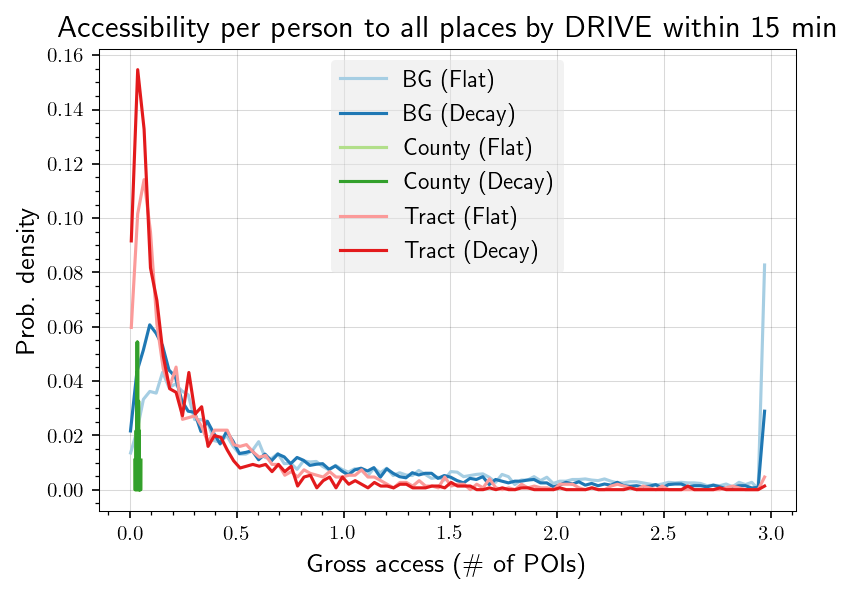

In [18]:
ax = U.plot(size=(6, 4), xlab='Gross access (\# of POIs)', ylab='Prob. density',
            title='Accessibility per person to all places by DRIVE within 15 min')
d2 = df.assign(scale=df.geoid.str.len().map({5: 'County', 11: 'Tract', 12: 'BG'}))
colors = iter(sns.color_palette('Paired', 6))
for (scale, wt_decay), d3 in d2.groupby(['scale', 'wt_decay']):
    y, x = np.histogram(d3.access.clip(0, 3), bins=100)
    ax.plot(x[:-1], y / y.sum(), lw=1.5, color=next(colors),
            label=f'{scale} ({"Decay" if wt_decay else "Flat"})')
ax.legend();

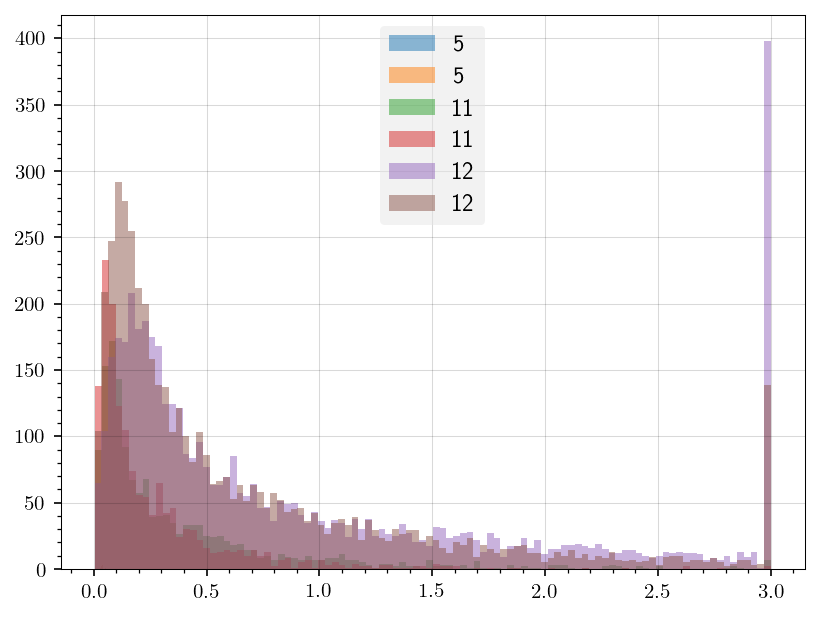

In [19]:
((df.assign(scale=df.geoid.str.len(), access=df.access.clip(0, 3))
  .groupby(['scale', 'wt_decay']).access.hist(bins=100, alpha=0.5, legend=True)));

In [20]:
xs.groupby(['purpose', 'kind']).size().pipe(lambda x: x[x > 0])

purpose              kind      
Overall              Overall       511628
Services             Overall       511628
                     Primary       476952
                     Secondary     505880
Shopping             Essential     475708
                     Overall       511628
                     Specialty     475452
Social/Recreational  Food/Drink    462352
                     Overall       511628
                     Recreation    446060
                     Religious     481484
dtype: int64

In [21]:
xs['mode'].value_counts()

mode
DRIVE      1408544
BIKE       1383048
TRANSIT    1290688
WALK       1288120
Name: count, dtype: int64

In [22]:
xs.thresh.value_counts()

thresh
90    1094320
60    1092776
45    1084448
30    1068480
15    1030376
Name: count, dtype: int64

In [23]:
xs.geoid.nunique()

6407

In [24]:
xs.wt_decay.value_counts()

wt_decay
False    2685200
True     2685200
Name: count, dtype: int64

In [25]:
xs['mode'].nunique()

4

In [37]:
xsIN = (xs.query('purpose=="Overall" & kind=="Overall" & mode=="DRIVE" & thresh=="60" & wt_decay & ~per_person')
        [['geoid', 'access']]).disp()

6,407 rows x 2 cols; Memory: 0.8 MiB


geoid       access
    <category>    <float32>
67       18001  1864.362915

In [107]:
xsIN2 = (xs.query('purpose=="Overall" & kind=="Overall" & mode=="DRIVE" & thresh=="60" & wt_decay & per_person')
        [['geoid', 'access']]).disp()

6,407 rows x 2 cols; Memory: 0.8 MiB


geoid     access
         <category>  <float32>
2685267       18001   0.052701

In [38]:
zones = gpd.read_parquet('../data/zones/in_2010.parquet').set_crs(CRS_DEG).disp()

6,417 rows x 7 cols; Memory: 1.8 MiB; CRS: EPSG:4326


geoid     scale         cbsa    county      aland   awater  \
   <object>  <object>     <object>  <object>    <int64>  <int64>   
0     18001    COUNTY  Decatur, IN     Adams  878078983  2430463   

                                            geometry  
                                          <geometry>  
0  POLYGON ((-84.80234 40.834685, -84.802336 40.8...

In [39]:
poi = gpd.read_parquet('../data/pois/in_2020.parquet').set_crs(CRS_DEG).disp()

80,742 rows x 8 cols; Memory: 24.9 MiB; CRS: EPSG:4326


id   purpose       kind  \
              <object>  <object>   <object>   
0  zzw-223@5py-97y-gzf  Shopping  Specialty   

                           sg_category                      geometry  \
                              <object>                    <geometry>   
0  Other Miscellaneous Store Retailers  POINT (-86.530296 39.139484)   

         area   visits visitors  
    <float64>  <int32>  <int32>  
0  424.752699      244      117

In [40]:
npoi = poi.sjoin(zones, predicate='within').groupby('geoid').size().rename('npoi').reset_index().disp()

6,318 rows x 2 cols; Memory: 0.5 MiB


geoid     npoi
   <object>  <int64>
0     18001      451

In [ ]:
acs = pd.read_parquet('../data/ses/acs_in_2019.parquet').disp()

6,407 rows x 25 cols; Memory: 1.9 MiB


scale     geoid       popu pop_density    p_minor      p_poc   p_lowedu  \
   <object>  <object>  <float64>   <float64>  <float64>  <float64>  <float64>   
0    COUNTY     18069    36359.0   95.018712   0.159328   0.041503   0.436188   

    m_income      p_pov   p_pov150   p_pov200     p_snap p_unemploy  \
   <float64>  <float64>  <float64>  <float64>  <float64>  <float64>   
0    0.78868   0.109009   0.147371    0.21833   0.084588   0.027811   

   p_noinsur p_disabled p_lowenglish p_snglparent  p_crowded   p_renter  \
   <float64>  <float64>    <float64>    <float64>  <float64>  <float64>   
0   0.078407   0.268824     0.003963     0.192825   0.009632    0.23065   

  p_mobilehome    p_noveh m_hhperveh    p_nowfh  p_transit p_walkbike  
     <float64>  <float64>  <float64>  <float64>  <float64>  <float64>  
0     0.020586   0.047144   0.504535   0.966263   0.001419   0.031736

In [88]:
xspoi = xsIN.merge(npoi, 'left', 'geoid').fillna(0).astype(D(npoi=int))
xspoi = xspoi.merge(acs[['geoid', 'scale', 'popu']])
xspoi = xspoi.merge(zones[['geoid', 'county']]).disp()

6,407 rows x 6 cols; Memory: 1.3 MiB


geoid       access     npoi     scale       popu    county
   <object>    <float32>  <int64>  <object>  <float64>  <object>
0     18001  1864.362915      451    COUNTY    35376.0     Adams

In [108]:
xspoi2 = (xsIN2.merge(npoi, 'left', 'geoid').fillna(0).astype(D(npoi=int))
          .merge(acs[['geoid', 'scale', 'popu']])
          .merge(zones[['geoid', 'county']])).disp()

6,407 rows x 6 cols; Memory: 1.3 MiB


geoid     access     npoi     scale       popu    county
   <object>  <float32>  <int64>  <object>  <float64>  <object>
0     18001   0.052701      451    COUNTY    35376.0     Adams

In [84]:
import plotly.express as px

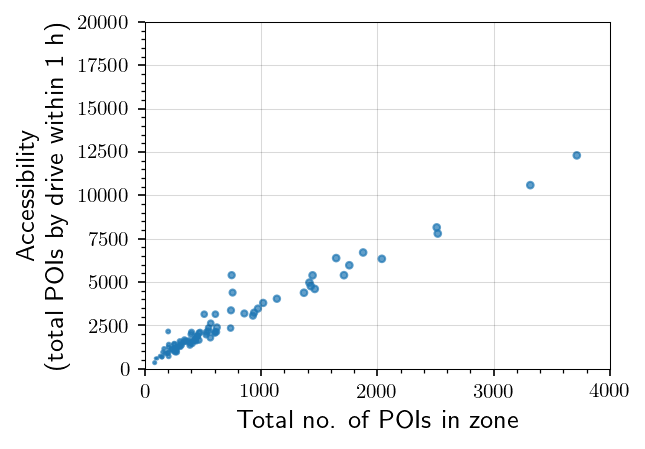

In [117]:
ax = U.plot(size=(4, 3), dpi=150, xlim=(0, 4000), ylim=(0, 20000),
            xlab='Total no. of POIs in zone', ylab='Accessibility\n(total POIs by drive within 1 h)')
dftot = xspoi.query('scale=="COUNTY"')
ax.scatter(dftot.npoi, dftot.access, s=10 * U.normalize(np.log10(1 + dftot.popu.clip(0, 100000))), alpha=0.7)
# ax.plot([0, 4000], [0, 4000], '--k', lw=0.5)

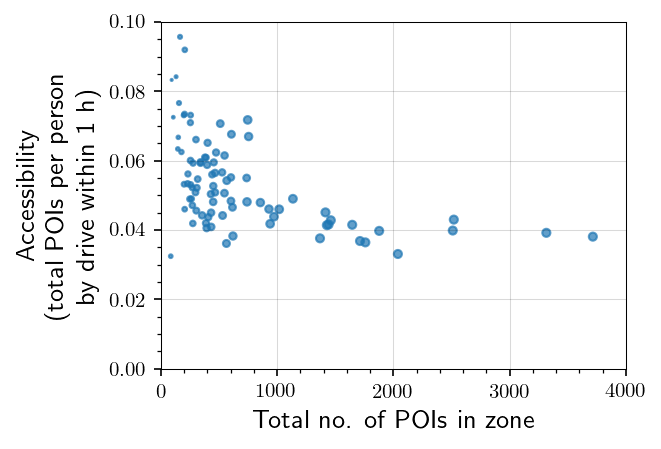

In [118]:
ax = U.plot(size=(4, 3), dpi=150, xlim=(0, 4000), ylim=(0, 0.1),
            xlab='Total no. of POIs in zone', ylab='Accessibility\n(total POIs per person\nby drive within 1 h)')
dfpp = xspoi2.query('scale=="COUNTY"')
ax.scatter(dfpp.npoi, dfpp.access, s=15 * U.normalize(np.log2(1 + dfpp.popu.clip(0, 100000))), alpha=0.7)

<Axes: xlabel='Total no. of POIs in zone', ylabel='Accessibility\n(total POIs by drive within 1 h)'>

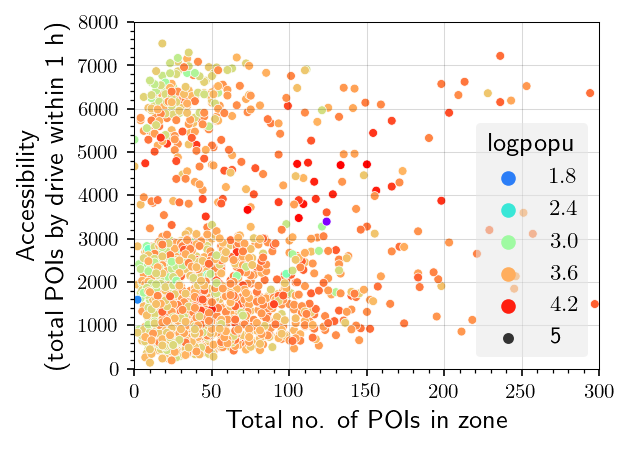

In [105]:
ax = U.plot(size=(4, 3), dpi=150, xlim=(0, 300), ylim=(0, 8000),
            xlab='Total no. of POIs in zone', ylab='Accessibility\n(total POIs by drive within 1 h)')
df2 = xspoi.query('scale=="TRACT"').assign(logpopu=lambda df: np.log10(1 + df.popu))
sns.scatterplot(df2, ax=ax, x='npoi', y='access', hue='logpopu', legend=True, size=5, palette='rainbow')
# ax.plot([0, 300], [0, 300], '--k', lw=0.8)
# ax.scatter(df2.npoi, df2.access, s=10, c=U.normalize(np.log10(1 + df2.popu.clip(0, 100000))), alpha=0.7)
# ax.legend()

In [91]:
px.scatter(df, x='npoi', y='access', hover_name='county')

In [119]:
px.scatter(dfpp, x='npoi', y='access', hover_name='county')